<a href="https://colab.research.google.com/github/leidysguerrero120/Trabajo-Analitica-3---RRHH/blob/main/b_Procesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import sqlite3
from datetime import datetime


In [44]:
##Cargamos los datos en DataFrames de pandas
employee_survey_data = pd.read_csv('/content/drive/MyDrive/leidys.guerrero@udea.edu.co 2024-09-12 19:06/TRABAJO HR/employee_survey_data.csv')
manager_survey_data = pd.read_csv('/content/drive/MyDrive/leidys.guerrero@udea.edu.co 2024-09-12 19:06/TRABAJO HR/manager_survey.csv')
general_data = pd.read_csv('/content/drive/MyDrive/leidys.guerrero@udea.edu.co 2024-09-12 19:06/TRABAJO HR/general_data.csv')
retirement_info = pd.read_csv('/content/drive/MyDrive/leidys.guerrero@udea.edu.co 2024-09-12 19:06/TRABAJO HR/retirement_info.csv')


In [45]:
##Conexión a la base de datos SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

##Creamos las tablas en SQLite
cursor.execute('''
CREATE TABLE general_data_a (
    Age INTEGER,
    BusinessTravel TEXT,
    Department TEXT,
    DistanceFromHome INTEGER,
    Education INTEGER,
    EducationField TEXT,
    EmployeeCount INTEGER,
    EmployeeID INTEGER PRIMARY KEY,
    Gender TEXT,
    JobLevel INTEGER,
    JobRole TEXT,
    MaritalStatus TEXT,
    MonthlyIncome INTEGER,
    NumCompaniesWorked INTEGER,
    Over18 TEXT,
    PercentSalaryHike INTEGER,
    StandardHours INTEGER,
    StockOptionLevel INTEGER,
    TotalWorkingYears INTEGER,
    TrainingTimesLastYear INTEGER,
    YearsAtCompany INTEGER,
    YearsSinceLastPromotion INTEGER,
    YearsWithCurrManager INTEGER,
    InfoDate TEXT
)
''')

cursor.execute('''
CREATE TABLE employee_survey_data_a (
    EmployeeID INTEGER PRIMARY KEY,
    EnvironmentSatisfaction INTEGER,
    JobSatisfaction INTEGER,
    WorkLifeBalance INTEGER,
    DateSurvey TEXT
)
''')

cursor.execute('''
CREATE TABLE manager_survey_a (
    EmployeeID INTEGER PRIMARY KEY,
    JobInvolvement INTEGER,
    PerformanceRating INTEGER,
    SurveyDate TEXT
)
''')

##Insertamos los datos en las tablas
general_data.to_sql('general_data_a', conn, if_exists='replace', index=False)
employee_survey_data.to_sql('employee_survey_data_a', conn, if_exists='replace', index=False)
manager_survey_data.to_sql('manager_survey_a', conn, if_exists='replace', index=False)
retirement_info.to_sql('retirement_info', conn, if_exists='replace', index=False)


711

In [46]:
cursor.execute('''
UPDATE general_data_a SET InfoDate = substr(InfoDate, 1, 10)
''')
cursor.execute('''
UPDATE employee_survey_data_a SET DateSurvey = substr(DateSurvey, 1, 10)
''')
cursor.execute('''
UPDATE manager_survey_a SET SurveyDate = substr(SurveyDate, 1, 10)
''')


In [47]:
general_data_2015 = pd.read_sql_query("SELECT * FROM general_data_a WHERE substr(InfoDate, 1, 4) = '2015'", conn)
general_data_2016 = pd.read_sql_query("SELECT * FROM general_data_a WHERE substr(InfoDate, 1, 4) = '2016'", conn)

employee_survey_data_2015 = pd.read_sql_query("SELECT * FROM employee_survey_data_a WHERE substr(DateSurvey, 1, 4) = '2015'", conn)
employee_survey_data_2016 = pd.read_sql_query("SELECT * FROM employee_survey_data_a WHERE substr(DateSurvey, 1, 4) = '2016'", conn)

manager_survey_data_2015 = pd.read_sql_query("SELECT * FROM manager_survey_a WHERE substr(SurveyDate, 1, 4) = '2015'", conn)
manager_survey_data_2016 = pd.read_sql_query("SELECT * FROM manager_survey_a WHERE substr(SurveyDate, 1, 4) = '2016'", conn)


In [48]:
##Unimos las tablas de 2015
total_2015 = pd.merge(pd.merge(general_data_2015, employee_survey_data_2015, on='EmployeeID', how='left'),
                      manager_survey_data_2015, on='EmployeeID', how='left')

##Unimos las tablas de 2016
total_2016 = pd.merge(pd.merge(general_data_2016, employee_survey_data_2016, on='EmployeeID', how='left'),
                      manager_survey_data_2016, on='EmployeeID', how='left')

##Concatenamos los datos de 2015 y 2016
merged_total = pd.concat([total_2015, total_2016], ignore_index=True).drop_duplicates()


In [49]:
final_table = pd.merge(merged_total, retirement_info, on='EmployeeID', how='left')

final_table_cleaned = final_table[['EmployeeID', 'InfoDate', 'DateSurvey', 'SurveyDate']]


In [50]:
##Verificar duplicados
duplicate_count = final_table_cleaned.duplicated(subset='EmployeeID').sum()
print(f'Número de duplicados: {duplicate_count}')

##Mostrar los primeros registros
final_table_cleaned.head(10)


Número de duplicados: 3760


,EmployeeID,InfoDate,DateSurvey,SurveyDate
0,1,2015-12-31,2015-12-31,2015-12-31
1,2,2015-12-31,2015-12-31,2015-12-31
2,3,2015-12-31,2015-12-31,2015-12-31
3,4,2015-12-31,2015-12-31,2015-12-31
4,5,2015-12-31,2015-12-31,2015-12-31
5,6,2015-12-31,2015-12-31,2015-12-31
6,7,2015-12-31,2015-12-31,2015-12-31
7,8,2015-12-31,2015-12-31,2015-12-31
8,9,2015-12-31,2015-12-31,2015-12-31
9,10,2015-12-31,2015-12-31,2015-12-31


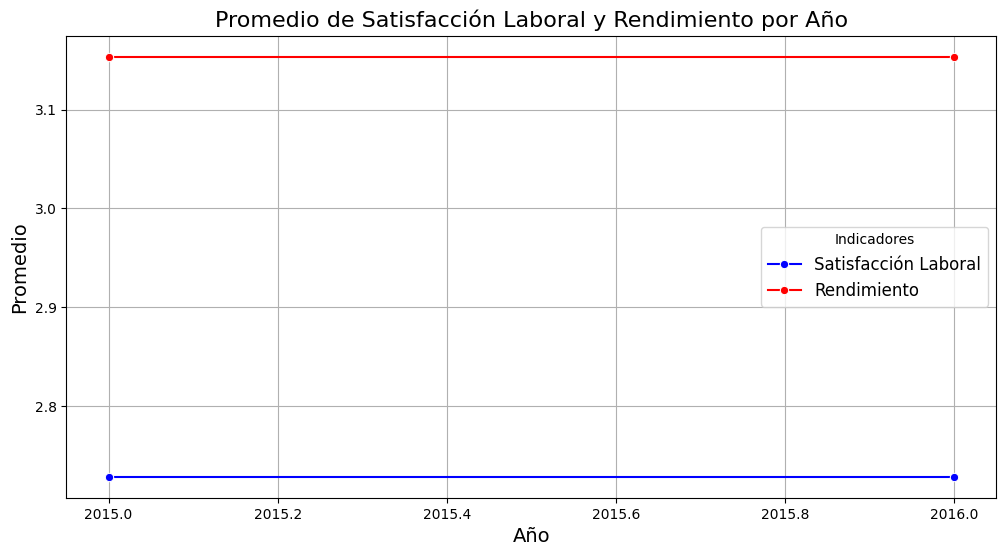

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

#Creamos un DataFrame con las columnas relevantes
df = final_table[['JobSatisfaction', 'PerformanceRating', 'InfoDate']].dropna()

#Convertimos la fecha a datetime para extraer el año
df['Year'] = pd.to_datetime(df['InfoDate']).dt.year

#Agrupamos por año y calculamos la satisfacción laboral y el rendimiento promedio
summary = df.groupby('Year').agg({
    'JobSatisfaction': 'mean',
    'PerformanceRating': 'mean'
}).reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=summary, x='Year', y='JobSatisfaction', marker='o', label='Satisfacción Laboral', color='b')
sns.lineplot(data=summary, x='Year', y='PerformanceRating', marker='o', label='Rendimiento', color='r')

plt.title('Promedio de Satisfacción Laboral y Rendimiento por Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Promedio', fontsize=14)
plt.legend(title='Indicadores', fontsize=12)

plt.grid(True)
plt.show()
